# MLP with floating point weights and baremetal C implementation

In [1]:
import os
import sys
import copy
import serial
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

import src.python.dataset.yalefaces as yalefaces
import src.python.model.util as util

In [2]:
np.random.seed(13)
torch.manual_seed(13)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load dataset
### Load and normalize the raw dataset

In [4]:
X, y = yalefaces.load("dataset/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

### Split dataset into train and test

In [5]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

### Compress dataset with PCA

In [6]:
num_train_faces, num_pixels = X_train_raw.shape
num_principal_components = int(num_train_faces)
pca = PCA(n_components=num_principal_components)

pca.fit(X)

X_train = pca.transform(X_train_raw)
X_test = pca.transform(X_test_raw)

### Convert datasets to pythorch tensors

In [7]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

## Train MLP

In [8]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(132, 96, bias=True),
      torch.nn.ReLU(),
      torch.nn.Linear(96, 15, bias=True),
    )

  def forward(self, x):
    return self.layers(x)

In [9]:
model = MLP()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [10]:
train_accs= []
train_losses = []

for epoch in range(50):
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    error, num_samples = util.train(model, device, train_data, optimizer)
    loss = float(error)/float(num_samples)
    train_losses.append(loss)
    
    acc = util.test(model, device, train_data)
    train_accs.append(acc)

Text(0.5, 1.0, 'Train Loss')

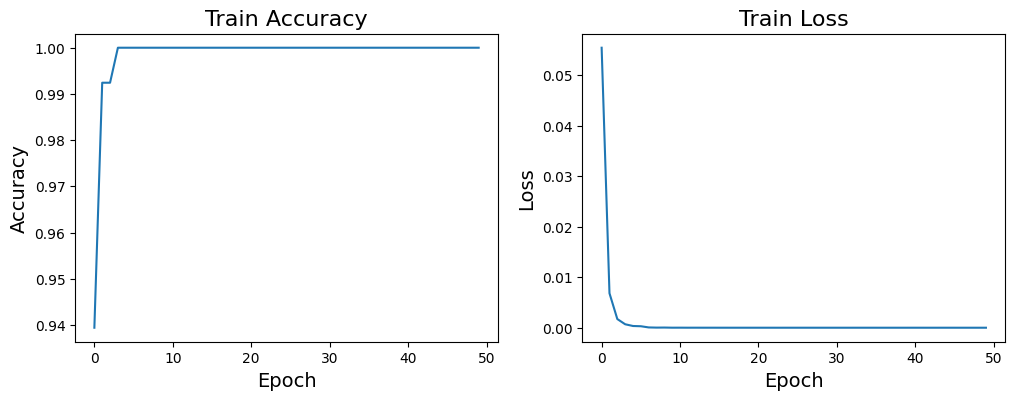

In [16]:
plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
ax.plot(train_accs, label="Train accuracy")
ax.set_xlabel("Epoch", fontdict={"fontsize": 14})
ax.set_ylabel("Accuracy", fontdict={"fontsize": 14})
ax.set_title("Train Accuracy", fontdict={"fontsize": 16})

ax = plt.subplot(1,2,2)
ax.plot(train_losses, label="Train loss")
ax.set_xlabel("Epoch", fontdict={"fontsize": 14})
ax.set_ylabel("Loss", fontdict={"fontsize": 14})
ax.set_title("Train Loss", fontdict={"fontsize": 16})

In [12]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = util.test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 90.91


## Quantize model

In [17]:
# copy our original model
qmodel_float = copy.deepcopy(model.layers)
qmodel_float.eval()

Sequential(
  (0): Linear(in_features=132, out_features=96, bias=True)
  (1): ReLU()
  (2): Linear(in_features=96, out_features=15, bias=True)
)

In [18]:
# fuse layers (weights+activation)
torch.quantization.fuse_modules(qmodel_float, ['0', '1'], inplace=True)

# add quantization of input and output
qmodel_float = torch.nn.Sequential(
    torch.quantization.QuantStub(),
    *qmodel_float,
    torch.quantization.DeQuantStub()
)

In [19]:
# configure quantization
qmodel_float.qconfig = torch.quantization.default_qconfig
qmodel_float=qmodel_float.to('cpu')
qmodel_float.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})

In [20]:
# initialize quantization parameters
torch.quantization.prepare(qmodel_float, inplace=True)

Sequential(
  (0): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (1): LinearReLU(
    (0): Linear(in_features=132, out_features=96, bias=True)
    (1): ReLU()
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
  (3): Linear(
    in_features=96, out_features=15, bias=True
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (4): DeQuantStub()
)

In [21]:
# learn quantization parameters from test samples
with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(test_data):
        x,y = x.to('cpu'), y.to('cpu')
        qmodel_float(x)

# quantize weights
qmodel = torch.quantization.convert(qmodel_float, inplace=False)

In [22]:
print("Weight size before quantization:", qmodel_float[1][0].weight.element_size(), "byte(s)")
print("Weight size after quantization:", qmodel[1].weight().element_size(), "byte(s)")

Weight size before quantization: 4 byte(s)
Weight size after quantization: 1 byte(s)


In [23]:
# measure accuracy of the quantized model
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = util.test(qmodel, 'cpu', test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 87.88


### Save models

In [24]:
def print_model_size(mdl, name, filename='tmp.pt'):
    torch.save(mdl.state_dict(), filename)
    print(f"{name}: %.3f KB" %(os.path.getsize(filename)/1e3))

print_model_size(model, "Original ", "mlp.pt")
print_model_size(qmodel, "Quantized", "mlp_quant.pt")

Original : 58.399 KB
Quantized: 17.863 KB


## Export model weights as C code

In [25]:
model_params = model.state_dict()
qmodel_params = qmodel.state_dict()

In [26]:
layer_indexes = [1, 3]

src_filename = 'src/embedded/mlp-face-recognition/esp32s3/main/mlp_weights.c'
hdr_filename = 'src/embedded/mlp-face-recognition/esp32s3/include/mlp_weights.h'

model.cpu()

with open(src_filename, 'w') as source, open(hdr_filename, 'w') as header:

    # header preamble
    header.write('#ifndef MLP_WEIGHTS\n#define MLP_WEIGHTS\n\n')
    header.write('#include <stdint.h>\n\n')

    # source includes
    source.write('#include "mlp_weights.h"\n\n')

    for layer in layer_indexes:
        layer_shape = util.get_weights(model_params, layer-1).shape
        if layer == 1:
            header.write(f"#define LAYER_INPUT_LEN {layer_shape[1]}\n")
        header.write(f"#define LAYER_{layer}_LEN {layer_shape[0]}\n")
    header.write("\n")

    # input: quantization params
    x_scale, x_zero = util.get_input_qparams(qmodel_params)
    header.write(f"extern const float input_zero;\n")
    header.write(f"extern const float input_scale;\n\n")
    source.write(f"const float input_zero = {x_zero};\n")
    source.write(f"const float input_scale = {x_scale};\n\n")

    for layer in layer_indexes:
        weights = util.get_weights(model_params, layer-1).flatten()
        weights_scale, layer_scale = util.get_scale(qmodel_params, layer)
        weights_zero, layer_zero = util.get_zero(qmodel_params, layer)

        # quantize weights and bias
        qweights = (np.around(weights / weights_scale) + weights_zero).astype(int)
        qweights -= weights_zero

        # layer and weights: quantization params
        header.write(f"extern const int8_t layer_{layer}_weights_zero;\n")
        header.write(f"extern const float layer_{layer}_weights_scale;\n\n")
        header.write(f"extern const int8_t layer_{layer}_zero;\n")
        header.write(f"extern const float layer_{layer}_scale;\n\n")

        source.write(f"const int8_t layer_{layer}_weights_zero = {weights_zero};\n")
        source.write(f"const float layer_{layer}_weights_scale = {weights_scale};\n\n")
        source.write(f"const int8_t layer_{layer}_zero = {layer_zero};\n")
        source.write(f"const float layer_{layer}_scale = {layer_scale};\n\n")

        # Weights int8
        header.write(f"extern const int8_t layer_{layer}_weights8[{len(weights)}];\n")
        source.write(f"const int8_t layer_{layer}_weights8[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{qweights[i]}, ")
        source.write(f"{qweights[len(qweights)-1]}}};\n\n")

        # Weights int16
        header.write(f"extern const int16_t layer_{layer}_weights16[{len(weights)}];\n")
        source.write(f"const int16_t layer_{layer}_weights16[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{qweights[i]}, ")
        source.write(f"{qweights[len(qweights)-1]}}};\n\n")

        # Weights float
        header.write(f"extern const float layer_{layer}_weights[{len(weights)}];\n")
        source.write(f"const float layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights[i]}, ")
        source.write(f"{weights[len(weights)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

## Talk to esp32

In [27]:
CPU_FREQ_KHZ = 240000
num_tests = len(X_test)

MODES = {
    "float":  b'\x01',
    "floatv": b'\x03',
    "int8":   b'\x05',
    "int8v":  b'\x09'
}

with serial.Serial("/dev/ttyUSB0", baudrate=115200, timeout=None) as esp32, tqdm(total=num_tests, file=sys.stdout) as pbar:
    esp32.read_until(b'Ready\n')
    
    num_correct = 0
    all_elapsed = []

    for i in range(num_tests):
        face = X_test[i]
        expected = y_test[i]

        # msg = esp32.read_until(b'Waiting for input\n')
        expected_msg = b'Waiting for input\n'
        msg = esp32.read_until(expected_msg)
        
        # msg = esp32.read(len(expected_msg))
        assert msg == expected_msg, msg
        # assert msg.__contains__(expected_msg), msg

        # send command=1 (new inference)
        esp32.write(MODES["int8v"])

        # send input (132 bytes)
        esp32.write(face.tobytes())

        # read output
        subject = esp32.read(4)
        subject = int.from_bytes(subject, byteorder="little")

        # read inference duration
        elapsed = esp32.read(4)
        elapsed = int.from_bytes(elapsed, byteorder="little")
        all_elapsed.append(elapsed)

        # count correct inferences
        if expected == subject:
            num_correct += 1

        # update status
        acc = num_correct/(i+1)
        pbar.update(1)
        pbar.set_description(f"Accuracy = {acc*100:.2f}%, Average Inference Duration = {elapsed/CPU_FREQ_KHZ:.3f}ms")


  0%|          | 0/33 [00:00<?, ?it/s]

Accuracy = 87.88%, Average Inference Duration = 0.362ms: 100%|██████████| 33/33 [00:01<00:00, 18.77it/s]
